In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from config import DATA_FOLDER
from analysis import check_gies
import pandas as pd
import xarray as xr
import numpy as np

### Dataset to use - change this value to analyze a different data set

In [2]:
dataset = 'twenty'

### Load in parent probabilities and rates

In [3]:
dag_folders = check_gies.get_dag_folders(dataset)
true_dags = check_gies.get_true_dags(dag_folders)
print('loaded DAGs')
parent_probs_by_dag = check_gies.get_parent_probs_by_dag(dag_folders, 10)
print('Computed parent probabilities')

loaded DAGs
Loading parent probabilities for DAG 0
Loading parent probabilities for DAG 10
Loading parent probabilities for DAG 20
Loading parent probabilities for DAG 30
Loading parent probabilities for DAG 40
Computed parent probabilities


In [4]:
true_dags[0].parents[10]

{0, 1, 2, 3, 4, 8, 9}

[1.0]
[1.0]
[0.7142857142857143]
[0.75]
[0.5714285714285714]
[0.25]
[0.42857142857142855]
[0.16666666666666666]
[0.42857142857142855]
[0.16666666666666666]
[0.2857142857142857]
[0.0]
[0.14285714285714285]
[0.0]
[0.14285714285714285]
[0.0]
[0.14285714285714285]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[1.         0.79530159 0.66278571 0.55361111 0.47884127 0.40781746
 0.336      0.26954762 0.21880952 0.14204762 0.03466667]
[1.         0.67265825 0.47808445 0.32678619 0.24254734 0.16958215
 0.11103649 0.07101105 0.03266209 0.01265751 0.        ]


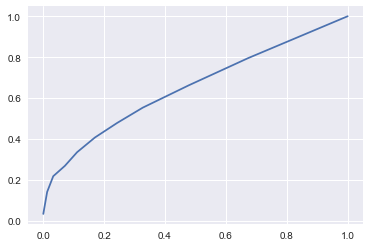

In [9]:
alphas = np.linspace(0, 1, 11)
avg_tprs = np.zeros(len(alphas))
avg_fprs = np.zeros(len(alphas))
for a_ix, alpha in enumerate(alphas):
    tprs = []
    fprs = []
    for dag_num, (true_dag, parent_probs_by_strat) in enumerate(zip(true_dags, parent_probs_by_dag)):
        true_parents = true_dag.parents[10]
        true_nonparents = true_dag.nodes - true_parents - {10}
        labelled_parents = {p for p, prob in parent_probs_by_strat['learn-parents,n=60,b=2,k=2'].items() if prob >= alpha}
        true_positives = true_parents & labelled_parents
        false_positives = true_nonparents & labelled_parents
        tprs.append(len(true_positives) / len(true_parents) if len(true_parents) != 0 else 1)
        fprs.append(len(false_positives) / len(true_nonparents) if len(true_nonparents) != 0 else 0)
        if dag_num == 0:
            print(tprs)
            print(fprs)
    avg_tprs[a_ix] = np.mean(tprs)
    avg_fprs[a_ix] = np.mean(fprs)

print(avg_tprs)
print(avg_fprs)
sort_ixs = np.argsort(avg_fprs)
plt.plot(avg_fprs[sort_ixs], avg_tprs[sort_ixs]);

In [6]:
strategy_names = ['random', 'edge-prob', 'learn-parents']
ns = [60, 120]
rates_da = check_gies.get_rates_data_array(
    parent_probs_by_dag,
    true_dags,
    target=10,
    strategy_names=strategy_names,
    ks=[2],
    bs=[2],
    ns=ns,
    alphas=np.linspace(0, 1, 11)
)
print(rates_da.dims)

Loading parent probabilities for DAG 0
learn-parents,n=60,b=2,k=2
{'tpr': 1.0, 'fpr': 1.0, 'tnr': 0.0, 'fnr': 1.7142857142857142, 'ppv': 0.3684210526315789, 'npv': 1}
learn-parents,n=60,b=2,k=2
{'tpr': 0.7142857142857143, 'fpr': 0.75, 'tnr': 0.25, 'fnr': 1.2857142857142858, 'ppv': 0.35714285714285715, 'npv': 0.6}
learn-parents,n=60,b=2,k=2
{'tpr': 0.5714285714285714, 'fpr': 0.25, 'tnr': 0.75, 'fnr': 0.42857142857142855, 'ppv': 0.5714285714285714, 'npv': 0.75}
learn-parents,n=60,b=2,k=2
{'tpr': 0.42857142857142855, 'fpr': 0.16666666666666666, 'tnr': 0.8333333333333334, 'fnr': 0.2857142857142857, 'ppv': 0.6, 'npv': 0.7142857142857143}
learn-parents,n=60,b=2,k=2
{'tpr': 0.42857142857142855, 'fpr': 0.16666666666666666, 'tnr': 0.8333333333333334, 'fnr': 0.2857142857142857, 'ppv': 0.6, 'npv': 0.7142857142857143}
learn-parents,n=60,b=2,k=2
{'tpr': 0.2857142857142857, 'fpr': 0.0, 'tnr': 1.0, 'fnr': 0.0, 'ppv': 1.0, 'npv': 0.7058823529411765}
learn-parents,n=60,b=2,k=2
{'tpr': 0.142857142857142

{'tpr': 0.0, 'fpr': 0.0, 'tnr': 1.0, 'fnr': 0.0, 'ppv': 1, 'npv': 0.7894736842105263}
random,n=120,b=2,k=2
{'tpr': 1.0, 'fpr': 1.0, 'tnr': 0.0, 'fnr': 3.75, 'ppv': 0.21052631578947367, 'npv': 1}
random,n=120,b=2,k=2
{'tpr': 0.75, 'fpr': 0.6666666666666666, 'tnr': 0.3333333333333333, 'fnr': 2.5, 'ppv': 0.23076923076923078, 'npv': 0.8333333333333334}
random,n=120,b=2,k=2
{'tpr': 0.25, 'fpr': 0.4, 'tnr': 0.6, 'fnr': 1.5, 'ppv': 0.14285714285714285, 'npv': 0.75}
random,n=120,b=2,k=2
{'tpr': 0.0, 'fpr': 0.06666666666666667, 'tnr': 0.9333333333333333, 'fnr': 0.25, 'ppv': 0.0, 'npv': 0.7777777777777778}
random,n=120,b=2,k=2
{'tpr': 0.0, 'fpr': 0.06666666666666667, 'tnr': 0.9333333333333333, 'fnr': 0.25, 'ppv': 0.0, 'npv': 0.7777777777777778}
random,n=120,b=2,k=2
{'tpr': 0.0, 'fpr': 0.0, 'tnr': 1.0, 'fnr': 0.0, 'ppv': 1, 'npv': 0.7894736842105263}
random,n=120,b=2,k=2
{'tpr': 0.0, 'fpr': 0.0, 'tnr': 1.0, 'fnr': 0.0, 'ppv': 1, 'npv': 0.7894736842105263}
random,n=120,b=2,k=2
{'tpr': 0.0, 'fpr': 

{'tpr': 0.6666666666666666, 'fpr': 0.1875, 'tnr': 0.8125, 'fnr': 1.0, 'ppv': 0.4, 'npv': 0.9285714285714286}
random,n=60,b=2,k=2
{'tpr': 0.6666666666666666, 'fpr': 0.1875, 'tnr': 0.8125, 'fnr': 1.0, 'ppv': 0.4, 'npv': 0.9285714285714286}
random,n=60,b=2,k=2
{'tpr': 0.6666666666666666, 'fpr': 0.1875, 'tnr': 0.8125, 'fnr': 1.0, 'ppv': 0.4, 'npv': 0.9285714285714286}
random,n=60,b=2,k=2
{'tpr': 0.3333333333333333, 'fpr': 0.0625, 'tnr': 0.9375, 'fnr': 0.3333333333333333, 'ppv': 0.5, 'npv': 0.8823529411764706}
random,n=60,b=2,k=2
{'tpr': 0.3333333333333333, 'fpr': 0.0, 'tnr': 1.0, 'fnr': 0.0, 'ppv': 1.0, 'npv': 0.8888888888888888}
random,n=60,b=2,k=2
{'tpr': 0.0, 'fpr': 0.0, 'tnr': 1.0, 'fnr': 0.0, 'ppv': 1, 'npv': 0.8421052631578947}
random,n=120,b=2,k=2
{'tpr': 1.0, 'fpr': 1.0, 'tnr': 0.0, 'fnr': 5.333333333333333, 'ppv': 0.15789473684210525, 'npv': 1}
random,n=120,b=2,k=2
{'tpr': 1.0, 'fpr': 0.875, 'tnr': 0.125, 'fnr': 4.666666666666667, 'ppv': 0.17647058823529413, 'npv': 1.0}
random,n=1

{'tpr': 0.4, 'fpr': 0.0, 'tnr': 1.0, 'fnr': 0.0, 'ppv': 1.0, 'npv': 0.8235294117647058}
edge-prob,n=120,b=2,k=2
{'tpr': 0.4, 'fpr': 0.0, 'tnr': 1.0, 'fnr': 0.0, 'ppv': 1.0, 'npv': 0.8235294117647058}
edge-prob,n=120,b=2,k=2
{'tpr': 0.2, 'fpr': 0.0, 'tnr': 1.0, 'fnr': 0.0, 'ppv': 1.0, 'npv': 0.7777777777777778}
edge-prob,n=120,b=2,k=2
{'tpr': 0.0, 'fpr': 0.0, 'tnr': 1.0, 'fnr': 0.0, 'ppv': 1, 'npv': 0.7368421052631579}
edge-prob,n=120,b=2,k=2
{'tpr': 0.0, 'fpr': 0.0, 'tnr': 1.0, 'fnr': 0.0, 'ppv': 1, 'npv': 0.7368421052631579}
edge-prob,n=60,b=2,k=2
{'tpr': 1.0, 'fpr': 1.0, 'tnr': 0.0, 'fnr': 2.8, 'ppv': 0.2631578947368421, 'npv': 1}
edge-prob,n=60,b=2,k=2
{'tpr': 0.8, 'fpr': 0.8571428571428571, 'tnr': 0.14285714285714285, 'fnr': 2.4, 'ppv': 0.25, 'npv': 0.6666666666666666}
edge-prob,n=60,b=2,k=2
{'tpr': 0.8, 'fpr': 0.6428571428571429, 'tnr': 0.35714285714285715, 'fnr': 1.8, 'ppv': 0.3076923076923077, 'npv': 0.8333333333333334}
edge-prob,n=60,b=2,k=2
{'tpr': 0.4, 'fpr': 0.14285714285714

### Plot curves for each strategy

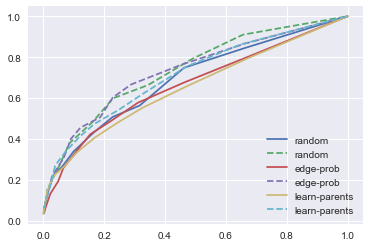

In [29]:
rate_avgs_da = rates_da.mean(dim='dag')
for strategy in strategy_names:
    for n, linestyle in zip(ns, ['-', '--']):
        strat_avg_tprs = rate_avgs_da.sel(strategy=strategy, b=2, k=2, n=n, rate='tpr').values
        strat_avg_fprs = rate_avgs_da.sel(strategy=strategy, b=2, k=2, n=n, rate='fpr').values

        sort_ixs = np.argsort(strat_avg_fprs)
        plt.plot(strat_avg_fprs[sort_ixs], strat_avg_tprs[sort_ixs], label=strategy, linestyle=linestyle)
plt.legend();